In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bangladeshis-flower/Kamini/img_aug_370_hflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_45_zoom.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_407_vflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_367_vflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_3_vflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_origonly_535_orig.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_245_hflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_319_zoom.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_310_zoom.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_80_hflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_372_orig.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_294_orig.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_315_zoom.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_94_hflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_428_orig.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_170_hflip.jpg


In [2]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder


import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms
from torchvision.io import read_image
from torchvision.models.swin_transformer import swin_s
import torch.nn.functional as F 
from torchvision.utils import make_grid


print(torch.__version__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

2.6.0+cu124
cuda:0


In [3]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder

path = "/kaggle/input/bangladeshis-flower"

data = {"imgpath": [], "labels": []}

# Traverse all directories and subdirectories
for root, dirs, files in os.walk(path):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):  # Add more extensions if needed
            fpath = os.path.join(root, file)
            # Extract label from the first folder under the main path
            label = os.path.relpath(fpath, path).split(os.sep)[0]
            data["imgpath"].append(fpath)
            data["labels"].append(label)

# Create DataFrame
df = pd.DataFrame(data)

# Encode labels
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

# Output
print("-------------Fetch files into a data frame-----------")
print(df.head())
print("-------------Path to an image file------------------")
print(df.loc[175]['imgpath']) 
print("-----------Number of images per category--------------")
print(df.labels.value_counts())


-------------Fetch files into a data frame-----------
                                             imgpath  labels  encoded_labels
0  /kaggle/input/bangladeshis-flower/Kamini/img_a...  Kamini               2
1  /kaggle/input/bangladeshis-flower/Kamini/img_a...  Kamini               2
2  /kaggle/input/bangladeshis-flower/Kamini/img_a...  Kamini               2
3  /kaggle/input/bangladeshis-flower/Kamini/img_a...  Kamini               2
4  /kaggle/input/bangladeshis-flower/Kamini/img_a...  Kamini               2
-------------Path to an image file------------------
/kaggle/input/bangladeshis-flower/Kamini/img_origonly_541_orig.jpg
-----------Number of images per category--------------
labels
Kamini          2000
Rainlily        2000
Sondhamaloti    2000
Kolaboti        2000
Madhobilota     2000
Gondhoraj       2000
Kathgulap       2000
Noyontara       2000
Zinnia          2000
Belly           2000
Name: count, dtype: int64


In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Shuffle the full dataset
df = df.sample(frac=1, random_state=124).reset_index(drop=True)

# Check if you have enough data
assert len(df) >= 20000, "Not enough samples in the dataset (need at least 20,000)"

# Split 16,000 for training
train_df = df.iloc[:16000].reset_index(drop=True)

# Split remaining 4,000 into validation (2k) and test (2k)
valid_df = df.iloc[16000:18000].reset_index(drop=True)
test_df  = df.iloc[18000:20000].reset_index(drop=True)

# Print details
print("############# Train Split ###################")
print(train_df.head(5))
print(train_df.shape)

print("############# Validation Split ##############")
print(valid_df.head(5))
print(valid_df.shape)

print("############# Test Split ####################")
print(test_df.head(5))
print(test_df.shape)


############# Train Split ###################
                                             imgpath     labels  \
0  /kaggle/input/bangladeshis-flower/Kathgulap/se...  Kathgulap   
1  /kaggle/input/bangladeshis-flower/Rainlily/img...   Rainlily   
2  /kaggle/input/bangladeshis-flower/Zinnia/orig_...     Zinnia   
3  /kaggle/input/bangladeshis-flower/Rainlily/img...   Rainlily   
4  /kaggle/input/bangladeshis-flower/Noyontara/im...  Noyontara   

   encoded_labels  
0               3  
1               7  
2               9  
3               7  
4               6  
(16000, 3)
############# Validation Split ##############
                                             imgpath        labels  \
0  /kaggle/input/bangladeshis-flower/Madhobilota/...   Madhobilota   
1  /kaggle/input/bangladeshis-flower/Sondhamaloti...  Sondhamaloti   
2  /kaggle/input/bangladeshis-flower/Noyontara/im...     Noyontara   
3  /kaggle/input/bangladeshis-flower/Rainlily/img...      Rainlily   
4  /kaggle/input/banglad

In [5]:
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    
}

In [6]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class FlowerDataset(Dataset):
    def __init__(self, img_data, transform=None):
        self.img_data = img_data
        self.transform = transform

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, index):
        img_path = self.img_data.loc[index, 'imgpath']
        label = self.img_data.loc[index, 'encoded_labels']

        # Open image in RGB mode (important for 3-channel input)
        image = Image.open(img_path).convert("RGB")

        # Apply transform
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# Instantiate datasets
training_data = FlowerDataset(train_df, transform=image_transforms['train'])
validation_data = FlowerDataset(valid_df, transform=image_transforms['valid'])

print("okay")


okay


In [7]:
train_batch_size = 200
val_batch_size = 100

train_dataloader = DataLoader(training_data, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(validation_data, batch_size=val_batch_size , shuffle=True)

print(">> Number of Train Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(train_dataloader.dataset) , train_batch_size , len(train_dataloader)))
print(">> Number of Validiation Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(test_dataloader.dataset) , val_batch_size , len(test_dataloader)))
onebatch = iter(train_dataloader)
train_features, train_labels = next(onebatch)
print("----------Batch Shape--------")
print(f"Feature batch shape: {train_features.size()}")
print("----------Labels Shape--------")
print(f"Labels batch shape: {train_labels.size()}")

>> Number of Train Data : 16000 -- Batch Size : 200 -- Number of Batch : 80 
>> Number of Validiation Data : 2000 -- Batch Size : 100 -- Number of Batch : 20 
----------Batch Shape--------
Feature batch shape: torch.Size([200, 3, 224, 224])
----------Labels Shape--------
Labels batch shape: torch.Size([200])


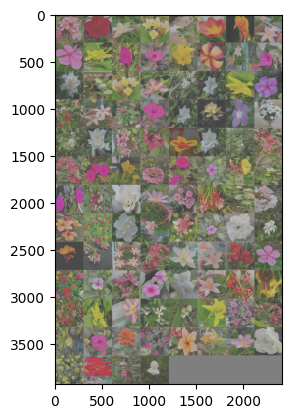

In [8]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
def imeshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0,2)
    plt.imshow(inp)
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(test_dataloader))

# Make a grid from batch
out = make_grid(inputs)
imeshow(out)


In [10]:
from torchvision.models import swin_s, Swin_S_Weights
import torch.nn as nn
import torch.optim as optim

# Load the model with pretrained weights
model = swin_s(weights=Swin_S_Weights.IMAGENET1K_V1)  # replaces deprecated `pretrained=True`

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Get input features of the final layer
n_inputs = model.head.in_features  # ✅ correctly define n_inputs first

# Replace the classification head
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 10)  # assuming 10 flower classes
)

# Move model to device
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(model.head.parameters(), lr=0.001)

print("Model ready ✅")


Model ready ✅


In [11]:
def train_model(model, optimizer, criterion , data_loader, device):

    model.train()
    running_loss = 0.0
    correct = 0
   
    
    for i, data in enumerate(data_loader):
        inputs , labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()       
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1) 
        correct += (predicted == labels).sum().item()
        running_loss += loss.item() * inputs.size(0) 
        
    
    avg_train_loss = running_loss / len(data_loader.dataset)
    avg_train_acc = ( correct / len(data_loader.dataset) ) * 100
    print(">>> Train loss {} ---- Accuracy Train {} ".format(avg_train_loss, avg_train_acc))
   
    
    return avg_train_loss , avg_train_acc

In [12]:
def test_model(model, criterion , data_loader, device):

    model.eval()    
  
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader):
           
            inputs , labels = data            
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item() 
        avg_val_acc = ( correct / len(data_loader.dataset) ) * 100
        avg_val_loss = val_loss / len(data_loader.dataset)  
                     
        print(">>> Validation loss {} ---- Validation Accuracy {} ".format(avg_val_loss, avg_val_acc))  
         
    return avg_val_loss , avg_val_acc

In [13]:
num_epochs = 10
history = {  "train_loss" : [] ,  "train_acc" : [] ,  "val_loss" : [] ,  "val_acc" : [] }
 
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    T_loss , T_acc = train_model(model , optimizer , criterion, train_dataloader , device)
    V_loss , V_acc = test_model(model , criterion , test_dataloader, device)

    history["train_loss"].append(T_loss)
    history["train_acc"].append(T_acc)
    history["val_loss"].append(V_loss)
    history["val_acc"].append(V_acc)

------------------ Training Epoch 1 ------------------
>>> Train loss 0.4318649124354124 ---- Accuracy Train 88.7875 
>>> Validation loss 0.18034339435398578 ---- Validation Accuracy 94.1 
------------------ Training Epoch 2 ------------------
>>> Train loss 0.09856066978536546 ---- Accuracy Train 97.1625 
>>> Validation loss 0.11941606365144253 ---- Validation Accuracy 96.2 
------------------ Training Epoch 3 ------------------
>>> Train loss 0.06692200799006968 ---- Accuracy Train 97.98125 
>>> Validation loss 0.07791201118379831 ---- Validation Accuracy 97.7 
------------------ Training Epoch 4 ------------------
>>> Train loss 0.05218594302423298 ---- Accuracy Train 98.5375 
>>> Validation loss 0.06856282949447631 ---- Validation Accuracy 98.0 
------------------ Training Epoch 5 ------------------
>>> Train loss 0.0450196276884526 ---- Accuracy Train 98.63125000000001 
>>> Validation loss 0.05787095930427313 ---- Validation Accuracy 98.15 
------------------ Training Epoch 6 ----

In [14]:
def evaluate_model(model, criterion, data_loader, device, set_name="Validation"):
    model.eval()
    total_loss = 0.0
    correct = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader.dataset)
    avg_acc = 100.0 * correct / len(data_loader.dataset)

    print(f">>> {set_name} Loss: {avg_loss:.4f} --- {set_name} Accuracy: {avg_acc:.2f}%")
    return avg_loss, avg_acc


In [15]:
# Validation Accuracy
val_loss, val_acc = evaluate_model(model, criterion, test_dataloader, device, set_name="Validation")

# Test Accuracy (assuming you have test_df and test_dataloader defined)
test_data = FlowerDataset(test_df, transform=image_transforms['valid'])
test_dataloader = DataLoader(test_data, batch_size=100, shuffle=False)

test_loss, test_acc = evaluate_model(model, criterion, test_dataloader, device, set_name="Test")


>>> Validation Loss: 0.0350 --- Validation Accuracy: 99.05%
>>> Test Loss: 0.0348 --- Test Accuracy: 98.70%


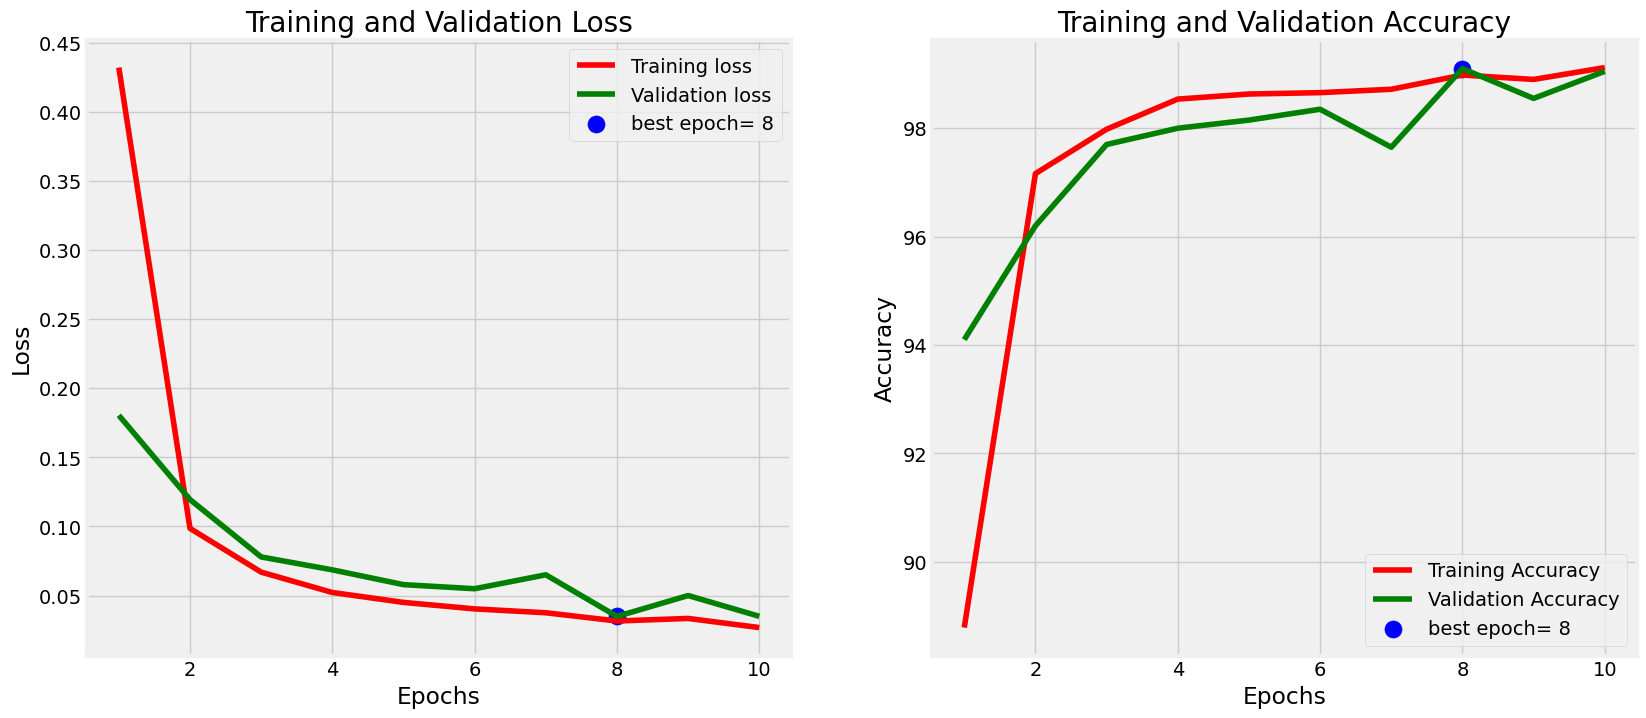

In [16]:
# Define needed variables
tr_acc = history["train_acc"]
tr_loss = history["train_loss"]
val_acc = history["val_acc"]
val_loss = history["val_loss"]


index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [28]:
test_data = FlowerDataset(test_df, transform=image_transforms['valid'])
test_loader = DataLoader(test_data, batch_size=100, shuffle=False)


In [29]:
inputs, labels = next(iter(test_loader))
print("Input shape:", inputs.shape)
model.eval()
with torch.no_grad():
    outputs = model(inputs.to(device))
    _, preds = torch.max(outputs, 1)
print("Predicted:", preds[:5].cpu().numpy())
print("Labels:", labels[:5].numpy())


Input shape: torch.Size([100, 3, 300, 300])
Predicted: [2 4 5 4 4]
Labels: [2 4 5 4 4]


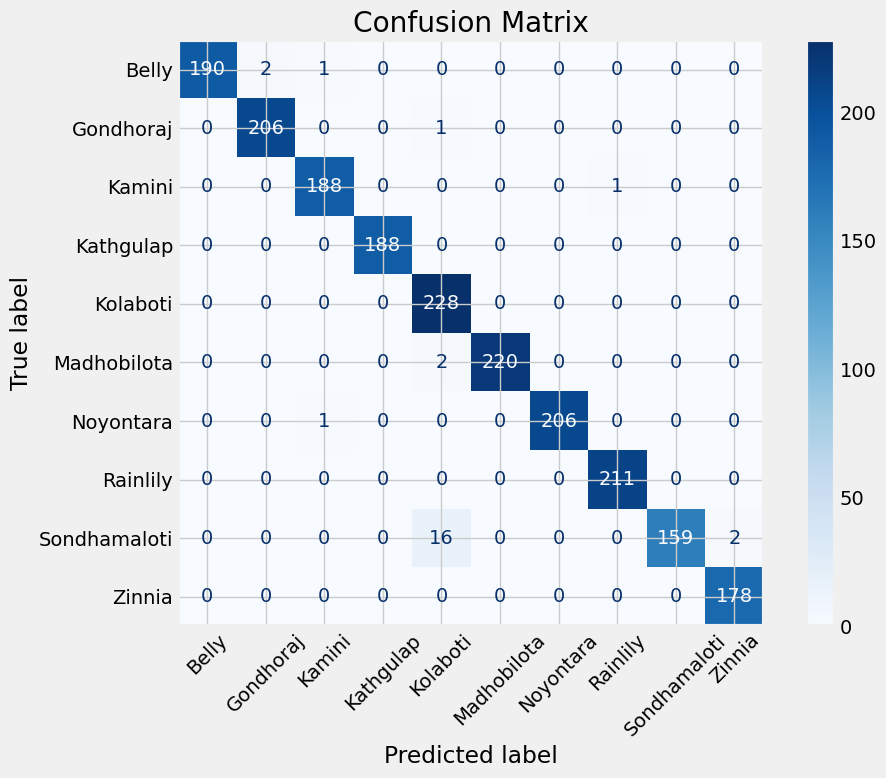

In [30]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_conf_matrix(model, data_loader, device, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()  # <-- required to display in notebook

# Usage
class_names = lb.classes_  # LabelEncoder().fit(classes) was used before
plot_conf_matrix(model, test_loader, device, class_names)


In [32]:
class_names = lb.classes_  # From LabelEncoder

classification_matrix = get_classification_matrix(model, test_loader, device, class_names)

# Display the matrix
print("Classification Matrix:\n")
print(classification_matrix.round(2))  # Round for cleaner output


Classification Matrix:

              precision  recall  f1-score  support
Belly              1.00    0.98      0.99   193.00
Gondhoraj          0.99    1.00      0.99   207.00
Kamini             0.99    0.99      0.99   189.00
Kathgulap          1.00    1.00      1.00   188.00
Kolaboti           0.92    1.00      0.96   228.00
Madhobilota        1.00    0.99      1.00   222.00
Noyontara          1.00    1.00      1.00   207.00
Rainlily           1.00    1.00      1.00   211.00
Sondhamaloti       1.00    0.90      0.95   177.00
Zinnia             0.99    1.00      0.99   178.00
accuracy           0.99    0.99      0.99     0.99
macro avg          0.99    0.99      0.99  2000.00
weighted avg       0.99    0.99      0.99  2000.00


In [34]:
# Save the model weights
torch.save(model.state_dict(), "flower_swin_model.pth")
print("Model saved successfully ✅")


Model saved successfully ✅


In [38]:
from IPython.display import FileLink

# Make sure file exists first
link = FileLink("flower_swin_model.pth")  # or .h5
link


/kaggle/working/flower_swin_model.pth

In [48]:
import torch
import torchvision.models as models
import torch.nn as nn

# Load base swin model without head
model = models.swin_s(pretrained=False)

# Replace the head with the structure matching your training
# Example: if you used a Sequential head with multiple layers
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(512, 10)  # replace num_classes with your actual number
)

# Now load weights
state_dict = torch.load('flower_swin_model.pth')
model.load_state_dict(state_dict)
model.eval()


SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       